In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from models.imavae import IMAVAE

import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# To make this notebook's output stable across runs
np.random.seed(2020)
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. Generate Data with observed covariates

By including observed covariates $\boldsymbol{w}$, we construct the dataset as follows:
\begin{align*}
\boldsymbol{w} &\sim \mathcal{N}(\boldsymbol{0}, \sigma_w^2 \textbf{I}) \\
t &\sim \text{Bernoulli}(\text{sigmoid}(\boldsymbol{\theta}^{\text{T}} \boldsymbol{w})) \\
\boldsymbol{z}_m &\sim \mathcal{N}(0, \sigma_m^2 \textbf{I}) + c_1 \mathbb{1}(t = 1) + c_2 g(\boldsymbol{w}) \\
\boldsymbol{x} &= f(\boldsymbol{z}_m) + c_3 \epsilon_{x} \\
y &= f_y (t, \boldsymbol{z}_m, \boldsymbol{w}) + \epsilon_{y}
\end{align*}
where $c_1, c_2, c_3 \in \mathbb{R}$ are constants, $\boldsymbol{\theta}$ is a coefficient vector, and $f$, $g$, and $f_y$ are nonlinear functions which are modeled by **un-trained** multi-layer perceptrons (MLPs). $\epsilon_{x}$ and $\epsilon_{y}$ are Gaussian noise terms.

In [2]:
N = 6000
c1, c2, c3, sigma_x, sigma_m, noise_scale = 4, 0.1, 0.1, 0.5, 1, 0.01
x_dim, z_m_dim, w_dim, hidden_dim, hidden_dim_fy = 50, 2, 20, 25, 10
f = nn.Sequential(
    nn.Linear(z_m_dim, hidden_dim), 
    nn.LeakyReLU(), 
    nn.Linear(hidden_dim, x_dim)
)
g = nn.Sequential(
    nn.Linear(w_dim, hidden_dim), 
    nn.LeakyReLU(), 
    nn.Linear(hidden_dim, z_m_dim)
)
fy = nn.Sequential(
    nn.Linear(z_m_dim+w_dim+1, hidden_dim_fy), 
    nn.LeakyReLU(), 
    nn.Linear(hidden_dim_fy, hidden_dim_fy), 
    nn.LeakyReLU(),
    nn.Linear(hidden_dim_fy, 1)
)

theta = np.random.uniform(-1,1,size=w_dim)
W = np.random.multivariate_normal(mean=np.zeros(w_dim), cov=sigma_x*np.eye(w_dim), size=N)
logit = W @ theta
T = np.random.binomial(n=1, p=[1/(1 + np.exp(-s)) for s in logit]).reshape(-1,1)
with torch.no_grad():
    gw = g(torch.tensor(W).float()).numpy()
Z_m0 = np.random.multivariate_normal(mean=np.zeros(z_m_dim), cov=sigma_m*np.eye(z_m_dim), size=N) + c2 * gw
Z_m1 = Z_m0 + c1
Z_m = np.array([Z_m0[i,:] if T[i][0] == 0 else Z_m1[i,:] for i in range(N)])
with torch.no_grad():
    X = f(torch.tensor(Z_m).float()).numpy()
    X += c3 * np.random.randn(X.shape[0],X.shape[1])
# alpha = np.random.uniform(-2,2,size=1)
# beta = np.random.uniform(-1,1,size=z_m_dim)
# gamma0 = np.random.uniform(-0.5,0.5,size=w_dim)
# gamma1 = np.random.uniform(-1,1,size=w_dim)
# gamma = np.array([gamma0 if T[i][0] == 0 else gamma1 for i in range(N)])
noise = noise_scale * np.random.normal(size=N)
# Y = (alpha * T.reshape(-1) + Z_m @ beta + np.sum(W*gamma,axis=1) + noise).reshape(-1,1)
Y = fy(torch.tensor(np.concatenate([T,Z_m,W],axis=1)).float()).detach().cpu().numpy() + noise.reshape(-1,1)

In [3]:
Y0_M0 = fy(torch.tensor(np.concatenate([np.zeros((N,1)),Z_m0,W],axis=1)).float()).detach().cpu().numpy() + noise.reshape(-1,1)
Y0_M1 = fy(torch.tensor(np.concatenate([np.zeros((N,1)),Z_m1,W],axis=1)).float()).detach().cpu().numpy() + noise.reshape(-1,1)
Y1_M0 = fy(torch.tensor(np.concatenate([np.ones((N,1)),Z_m0,W],axis=1)).float()).detach().cpu().numpy() + noise.reshape(-1,1)
Y1_M1 = fy(torch.tensor(np.concatenate([np.ones((N,1)),Z_m1,W],axis=1)).float()).detach().cpu().numpy() + noise.reshape(-1,1)
acme_c = (Y0_M1 - Y0_M0).mean()
acme_t = (Y1_M1 - Y1_M0).mean()
ade_c = (Y1_M0 - Y0_M0).mean()
ade_t = (Y1_M1 - Y0_M1).mean()
ate = (Y1_M1 - Y0_M0).mean()
print("True ACME (control) = {:.4f}".format(acme_c))
print("True ACME (treatment) = {:.4f}".format(acme_t))
print("True ADE (control) = {:.4f}".format(ade_c))
print("True ADE (treatment) = {:.4f}".format(ade_t))
print("True ATE = {:.4f}".format(ate))

True ACME (control) = -0.0791
True ACME (treatment) = -0.0729
True ADE (control) = -0.0054
True ADE (treatment) = 0.0008
True ATE = -0.0783


# 2. Fit IMAVAE on the dataset and evaluate mediation effect

In [4]:
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, 
               optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1.)
WT = np.concatenate([T,W], axis=1)
_ = imavae.fit(
    X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(WT, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(WT, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(WT, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(WT, treatment=True)
ate_mean, ate_std = imavae.ate_score(WT)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))
print("-------------------------------------")
print("ACME err (control) = {:.4f} +/- {:.4f}".format(abs(acme_c - acme_c_mean), acme_c_std))
print("ACME err (treatment) = {:.4f} +/- {:.4f}".format(abs(acme_t - acme_t_mean), acme_t_std))
print("ADE err (control) = {:.4f} +/- {:.4f}".format(abs(ade_c - ade_c_mean), ade_c_std))
print("ADE err (treatment) = {:.4f} +/- {:.4f}".format(abs(ade_t - ade_t_mean), ade_t_std))
print("ATE err = {:.4f} +/- {:.4f}".format(abs(ate - ate_mean), ate_std))

Beginning Training


Epoch: 199, Best Epoch: 187, Best Recon MSE: 0.0100168, Best Pred Metric [0.0011


Saving the last epoch with training MSE: 0.0100222 and Pred Metric: [0.0011303086, 0.0011303086]
Loaded the best model from Epoch: 187 with MSE: 0.0100168 and Pred Metric: [0.0011209483, 0.0011209483]
ACME (control) = -0.0433 +/- 0.0001
ACME (treatment) = -0.0433 +/- 0.0001
ADE (control) = -0.0363 +/- 0.0000
ADE (treatment) = -0.0363 +/- 0.0000
ATE = -0.0796 +/- 0.0001
-------------------------------------
ACME err (control) = 0.0358 +/- 0.0001
ACME err (treatment) = 0.0296 +/- 0.0001
ADE err (control) = 0.0309 +/- 0.0000
ADE err (treatment) = 0.0370 +/- 0.0000
ATE err = 0.0012 +/- 0.0001


### 2.1 Does the latent feature learned by IMAVAE recover the true mediator?

/var/folders/f7/ng9rrn3j6nq2wy53cjpq4bmr0000gp/T/ipykernel_4280/3984325954.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  axs[1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)


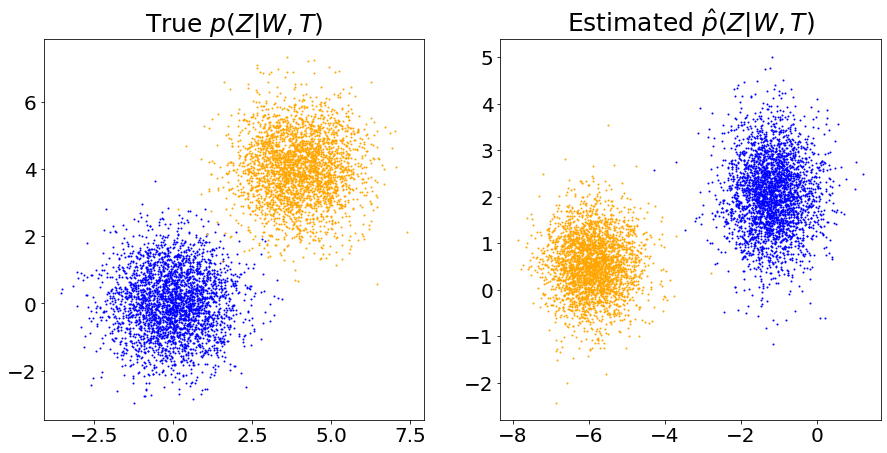

In [5]:
with torch.no_grad():
    t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
    t0, t1 = torch.cat([t0, torch.tensor(W).float()], dim=1), torch.cat([t1, torch.tensor(W).float()], dim=1)
    z_m0 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
    z_m1 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
    z_m = torch.stack([z_m0[i,:] if T[i,0] == 0 else z_m1[i,:] for i in range(N)])

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,7))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(Z_m[i,0], Z_m[i,1], c=c_dict[g], label=g, s=1)
    axs[1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_title("True $p(Z|W,T)$", size=25)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].set_title("Estimated $\hat{p}(Z|W,T)$", size=25)
plt.savefig('./Figures/case_b_lr.png', dpi=1200)

### 2.2 What if we use a multi-layer perception for $g_{\boldsymbol{\gamma}}$ ?

In [6]:
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, n_sup_hidden_layers=1,
                n_sup_hidden_dim=10, optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1.)
WT = np.concatenate([T,W], axis=1)
_ = imavae.fit(
    X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(WT, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(WT, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(WT, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(WT, treatment=True)
ate_mean, ate_std = imavae.ate_score(WT)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))
print("-------------------------------------")
print("ACME err (control) = {:.4f} +/- {:.4f}".format(abs(acme_c - acme_c_mean), acme_c_std))
print("ACME err (treatment) = {:.4f} +/- {:.4f}".format(abs(acme_t - acme_t_mean), acme_t_std))
print("ADE err (control) = {:.4f} +/- {:.4f}".format(abs(ade_c - ade_c_mean), ade_c_std))
print("ADE err (treatment) = {:.4f} +/- {:.4f}".format(abs(ade_t - ade_t_mean), ade_t_std))
print("ATE err = {:.4f} +/- {:.4f}".format(abs(ate - ate_mean), ate_std))

Beginning Training


Epoch: 199, Best Epoch: 199, Best Recon MSE: 0.00994849, Best Pred Metric [0.001


Saving the last epoch with training MSE: 0.00994849 and Pred Metric: [0.0012364319, 0.0012364319]
Loaded the best model from Epoch: 199 with MSE: 0.00994849 and Pred Metric: [0.0012364319, 0.0012364319]
ACME (control) = -0.0808 +/- 0.0002
ACME (treatment) = -0.0810 +/- 0.0002
ADE (control) = 0.0112 +/- 0.0000
ADE (treatment) = 0.0110 +/- 0.0000
ATE = -0.0698 +/- 0.0002
-------------------------------------
ACME err (control) = 0.0017 +/- 0.0002
ACME err (treatment) = 0.0081 +/- 0.0002
ADE err (control) = 0.0166 +/- 0.0000
ADE err (treatment) = 0.0102 +/- 0.0000
ATE err = 0.0085 +/- 0.0002


Text(0.5, 1.0, 'Estimated $\\hat{p}(Z|W,T)$')

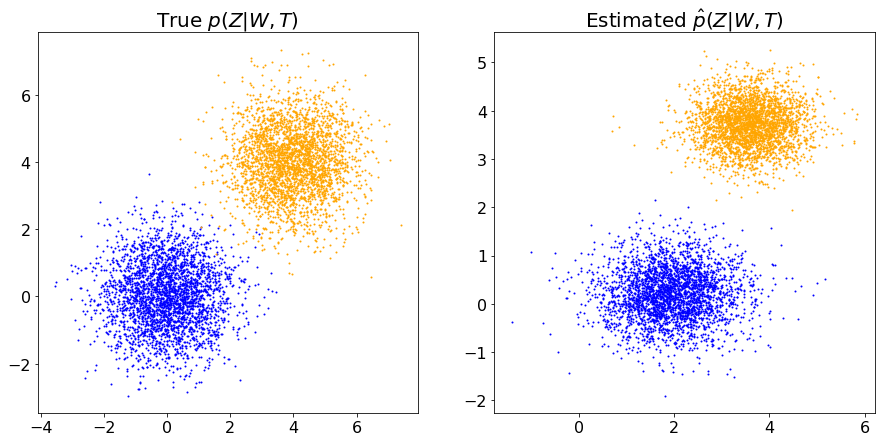

In [7]:
with torch.no_grad():
    t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
    t0, t1 = torch.cat([t0, torch.tensor(W).float()], dim=1), torch.cat([t1, torch.tensor(W).float()], dim=1)
    z_m0 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
    z_m1 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
    z_m = torch.stack([z_m0[i,:] if T[i,0] == 0 else z_m1[i,:] for i in range(N)])

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,7))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(Z_m[i,0], Z_m[i,1], c=c_dict[g], label=g, s=1)
    axs[1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)
axs[0].set_title("True $p(Z|W,T)$", size=20)
axs[1].set_title("Estimated $\hat{p}(Z|W,T)$", size=20)

#### 2.2.1 What if we increase the number of parameters of the MLP for $g_{\boldsymbol{\gamma}}$?

In [8]:
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, n_sup_hidden_layers=3,
                n_sup_hidden_dim=10, optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1.)
WT = np.concatenate([T,W], axis=1)
_ = imavae.fit(
    X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
    lr=1e-5, n_epochs=500, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(WT, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(WT, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(WT, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(WT, treatment=True)
ate_mean, ate_std = imavae.ate_score(WT)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))
print("-------------------------------------")
print("ACME err (control) = {:.4f} +/- {:.4f}".format(abs(acme_c - acme_c_mean), acme_c_std))
print("ACME err (treatment) = {:.4f} +/- {:.4f}".format(abs(acme_t - acme_t_mean), acme_t_std))
print("ADE err (control) = {:.4f} +/- {:.4f}".format(abs(ade_c - ade_c_mean), ade_c_std))
print("ADE err (treatment) = {:.4f} +/- {:.4f}".format(abs(ade_t - ade_t_mean), ade_t_std))
print("ATE err = {:.4f} +/- {:.4f}".format(abs(ate - ate_mean), ate_std))

Beginning Training


Epoch: 499, Best Epoch: 498, Best Recon MSE: 0.00997298, Best Pred Metric [0.001


Saving the last epoch with training MSE: 0.00996804 and Pred Metric: [0.0013908189, 0.0013908189]
Loaded the best model from Epoch: 498 with MSE: 0.00997298 and Pred Metric: [0.0012897658, 0.0012897658]
ACME (control) = -0.0715 +/- 0.0009
ACME (treatment) = -0.0756 +/- 0.0025
ADE (control) = 0.0008 +/- 0.0022
ADE (treatment) = -0.0036 +/- 0.0000
ATE = -0.0752 +/- 0.0010
-------------------------------------
ACME err (control) = 0.0076 +/- 0.0009
ACME err (treatment) = 0.0027 +/- 0.0025
ADE err (control) = 0.0062 +/- 0.0022
ADE err (treatment) = 0.0044 +/- 0.0000
ATE err = 0.0031 +/- 0.0010
